In [1]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from PIL import Image
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from datetime import datetime
import FinanceDataReader as fdr
import pandas_ta as ta
import os 
import pickle
import xgboost
import requests
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

try:
    import cust_f
except:
    pass
# to perform multiprocessing using a customized function (not necessary for Linux)

C:\Users\kimms\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\kimms\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\kimms\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
tot_run_time_start = time.time()

warnings.simplefilter('ignore', ConvergenceWarning)
print("\nStatsmodels' ConvergenceWarning is ignored")


Statsmodels' ConvergenceWarning is ignored


In [3]:
def Merge_FnG(input_df,shift_val=0,aver_val=0):
    url = ' https://api.alternative.me/fng/?limit=0'
    data = requests.get(url).json()
    value = []
    time = []
    for i in data['data']:
        value.append(i['value'])
        time.append(datetime.fromtimestamp(int(i['timestamp'])).strftime('%Y-%m-%d'))
    value = value[::-1]
    time = pd.to_datetime(time[::-1])
    fng = pd.Series(value,time,name='fng')
    fear_df=pd.DataFrame(fng)
    fear_df.reset_index(inplace=True)
    fear_df.columns = ['Date', 'fng_index']
    fear_df['fng_index']=pd.to_numeric(fear_df['fng_index'])
    ori_len=len(input_df)
    input_df=pd.merge(input_df,fear_df,how='outer',on='Date')
    input_df['fng_index']=input_df['fng_index'].fillna(44)
    # 2022_01_24까지 일단 슬라이싱
    input_df=input_df[:ori_len]
    
    if (shift_val !=0):
        input_df[f'fng_index_{shift_val}']=input_df['fng_index'].shift(shift_val)
        
    if (aver_val !=0):
        input_df[f'fng_index_{aver_val}mean']=input_df['fng_index'].rolling(window=aver_val).mean()

    
    input_df=input_df.fillna(method='bfill')
    
    return input_df

def Merge_NT(input_df,shift_val=0,aver_val=0):
    naver_trend_df=pd.read_csv("naver_trend.csv")
    naver_trend_df=naver_trend_df[6:]
    naver_trend_df=naver_trend_df.reset_index(drop=True)
    naver_trend_df.columns = ['Date', 'trend_index']
    naver_trend_df['Date'] = pd.to_datetime(naver_trend_df['Date'], format="%Y-%m-%d")
    naver_trend_df['trend_index']=pd.to_numeric(naver_trend_df['trend_index'])
    input_df=pd.merge(input_df,naver_trend_df,on='Date')
    
    if (shift_val !=0):
        input_df[f'trend_index_{shift_val}']=input_df['trend_index'].shift(shift_val)
        
    if (aver_val !=0):
        input_df[f'trend_index_{aver_val}mean']=input_df['trend_index'].rolling(window=aver_val).mean()
    
    input_df=input_df.fillna(method='ffill')
        
    return input_df

def Merge_pandas_ta(input_df):
    adx = input_df.ta.adx()
    macd = input_df.ta.macd(fast=14, slow=24)
    rsi = input_df.ta.rsi()
    df = pd.concat([input_df, adx, macd, rsi], axis=1)
    #결측치 처리
    predict_df = df
    predict_df2 = predict_df.dropna(axis=1, how='all')
    predict_df3 = predict_df2.interpolate(method='values')
    predict_df4 = predict_df3.dropna(axis=0, how='any')
    predict_df5 = predict_df4.drop(['High', 'Low'], axis=1)
    input_df=predict_df5
    return input_df

def Merge_DJI(input_df):
    start_date = str(input_df['Date'].iloc[0])
    end_date = str(input_df['Date'].iloc[-1])
    DJI_df = fdr.DataReader('dji', start_date, end_date).reset_index()
    dji_df=DJI_df.drop(['Open','High','Low','Change'],axis=1)
    dji_df.rename({'Close':'dji_c','Volume':'dji_v'},axis=1,inplace=True)
    input_df=pd.merge(input_df,dji_df,how='outer',on='Date')
    
    return input_df

def Merge_ECR(input_df):
    start_date = str(input_df['Date'].iloc[0])
    end_date = str(input_df['Date'].iloc[-1])
    exr=fdr.DataReader('USD/KRW', start_date, end_date).reset_index()
    exr=exr.drop(['Open','High','Low','Change'],axis=1)
    exr.rename({'Close':'exc_c'},axis=1,inplace=True)
    input_df=pd.merge(input_df,exr,how='outer',on='Date')
    input_df=input_df.fillna(method='ffill')
    input_df=input_df.fillna(method='bfill')
    
    return input_df

def Merge_HR(input_df):
    HR_3y_df=pd.read_csv("hash-rate_3y.csv")
    HR_all_df=pd.read_csv("hash-rate_alltime.csv")
    start_date=HR_3y_df['Timestamp'].iloc[0]
    inter_index=HR_all_df.index[HR_all_df['Timestamp']==start_date].tolist()[0]
    HR_df=HR_all_df[:inter_index]
    HR_df=pd.concat([HR_df,HR_3y_df])
    HR_df=pd.concat([HR_df,HR_3y_df])
    a=pd.date_range(start=str(input_df['Date'].iloc[0]),end=str(input_df['Date'].iloc[-1]))
    HR_ori_df=pd.DataFrame(a)
    HR_ori_df.rename({0:'Timestamp'},axis=1,inplace=True)
    
    for i in range(len(HR_ori_df['Timestamp'])):
        HR_df['Timestamp'] = pd.to_datetime(HR_df['Timestamp'], format="%Y-%m-%d")
    
    HR_ori_df=pd.merge(HR_ori_df,HR_df,how='outer',on='Timestamp')
    HR_ori_df=HR_ori_df.drop_duplicates()
    HR_ori_df
    
    HR_ori_df=HR_ori_df.drop_duplicates()
    HR_ori_df=HR_ori_df.fillna(method='ffill')
    HR_ori_df=HR_ori_df.fillna(method='bfill')
    HR_ori_df.rename({'Timestamp':'Date'},axis=1,inplace=True)

    input_df=pd.merge(input_df,HR_ori_df,on='Date')
    
    return input_df

def preprocessing(input_df, len_lag) :
    # 이동평균선 추가 5,10,20
    moving_avg=[5,10,20]
    for i in moving_avg:
        input_df[f'{i}_close']=-1
    for index in range(len(input_df)):
        for i in moving_avg:
            input_df[f'{i}_close']=input_df['Close'].rolling(window=i).mean()
        
    # p_lag:과거 가격, q_lag:과거 거래량 추가, pq_lag:거래대금 
    for lag in range(1,len_lag+1):
        input_df[f'p_lag_{lag}'] = -1
        input_df[f'q_lag_{lag}'] = -1 
        input_df[f'pq_lag_{lag}'] = -1
        for index in range(lag, len(input_df)):
            input_df.loc[index, f'p_lag_{lag}'] = input_df['Close'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
            input_df.loc[index, f'q_lag_{lag}'] = input_df['Volume'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가
            input_df.loc[index, f'pq_lag_{lag}'] = (input_df['Close'][index-lag]*input_df['Volume'][index-lag]) #1일전, 2일전, ... 거래량을 feature로 추가
            
def OBV_preprocessing(input_df):
    # OBV 산출 및 데이터 프레임에 추가 
    OBV=[]
    OBV.append(0)
    for i in range(1,len(input_df)):
        if input_df['Close'].iloc[i] > input_df['Close'].iloc[i-1]:
            OBV.append(OBV[-1]+input_df['Volume'].iloc[i])
        elif price_df['Close'].iloc[i]<input_df['Close'].iloc[i-1]:
            OBV.append(OBV[-1]-input_df['Volume'].iloc[i]) 
        else:
            OBV.append(OBV[-1])
            
    # OBV 추가
    input_df['obv']=OBV
    
    # 지수 평균 이동값 계산 
    input_df['obv_ema']=input_df['obv'].ewm(com=20).mean()
    
    # obv가 보통 지수를 위로 뚫으면 매수 신호 아래로 뚫으면 매도 신호 
    input_df['signal_obv']=input_df['obv']-input_df['obv_ema']
    
    moving_avg=[5,20,30]
    for i in moving_avg:
        input_df[f'obv_lag{i}']=-1
    for index in range(len(input_df)):
        for i in moving_avg:
            input_df[f'obv_lag{i}']=input_df['signal_obv'].rolling(window=i).mean()

def gen_train_test2(input_df):
    input_df['target']=0
    for i in range(len(input_df)-1):
        input_df['target'].iloc[i]=input_df['Close'].iloc[i+1]
        
def batch(iterable, batch_size, pt):
    """
    batch row 생성 이터레이터
    Args:
        iterable: iterable datastructure
        batch_size:
        pt: prediction term 예측 기간
    Returns:
        yield: batch row
    """

    l = len(iterable)
    for idx, ndx in tqdm(enumerate(range(0, l, pt))):
        yield idx, iterable[ndx: min(ndx + batch_size, l)]

        

def backtest_ma(test_df):
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df

def backtest_noise(test_df,ori_df):
    noise_ma = 30
    ori_df=ori_df[['High','Low']]
    df = test_df.copy()
    df=pd.merge(df,ori_df,right_index=True,left_index=True)
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_rsi(test_df):
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi
    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rsi_shift_1'] > 40), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, df['Close'] / df['Open'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df

def backtest_ma_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])

    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_rsi(test_df):
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df

def backtest_noise_and_rsi(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['rate'] = 0
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df


def backtest_ma_and_rsi_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df        


def backtest_XGB_1d(test_df: pd.DataFrame, ft: int, pt: int, plot=True) -> pd.DataFrame:
    """

    Args:
        test_df: 1시간 봉 데이터
        ft: fitting term 피팅 시킬 기간
        pt: prediction term 예측 기간
        arima_params:
    Returns:
        df: 예측 값이 열로 포함된 DataFrame
    """
    df = test_df.copy()
    batch_size = ft + pt
    total_loop = int(len(df) / pt) - 1
    result_columns = list(df.columns)
    result_columns.append("prediction_close")

    result_df = pd.DataFrame(columns=result_columns)

    try:
        for idx, batch_df in batch(df, batch_size, pt):
            # print(f'{idx}/{total_loop} running loop...')
            train, test = batch_df[:ft-1], batch_df[ft-1:ft]
            X_train, y_train = train.drop('target',axis=1,inplace=False),train['target']
            X_test, y_test = test.drop('target',axis=1,inplace=False),test['target']
            xgb = XGBRegressor()
            xgb.fit(X_train, y_train)
            pred = xgb.predict(X_test)
            if len(pred) ==0:
                break
            row = batch_df.iloc[[-1]]
            row['prediction_close'] = pred
            row['batch_open'] = batch_df.iloc[ft].Open
            result_df = pd.concat([result_df, row], axis=0)

    except IndexError:
        pass
    result_df['trade'] = np.where(result_df['batch_open'] < result_df['prediction_close'], 1, 0)
    result_df['ror'] = np.where(result_df['trade'] == 1, result_df['Close'] / result_df['batch_open'], 1)
    result_df['cr'] = result_df['ror'].cumprod()
    result_df['mdd'] = (result_df['cr'].cummax() - result_df['cr']) / result_df['cr'].cummax() * 100

    if plot:
        plot_result(result_df)
        plot_return(result_df)

    return result_df

def plot_result(df):
    plt.figure(figsize=(20, 8))
    l=list(df.index)
    for i in range(len(l)):
        l[i]=datetime.strptime(str(l[i])[:10],'%Y-%m-%d')
    plt.plot(l, df['Close'].values, color='b', label='real close')
    plt.plot(l, df['prediction_close'].values , color='r', label='prediction close')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_return(df):
    plt.figure(figsize=(20, 8))
    l=list(df.index)
    for i in range(len(l)):
        l[i]=datetime.strptime(str(l[i])[:10],'%Y-%m-%d')
    plt.plot(l, df['cr'].values , color='r', label='return')
    plt.legend()
    plt.title(
        f"mdd: {round(df['mdd'].max(), 2)}\nreturn_rate: {round(df['cr'].iloc[-1] * 100 - 100, 2)}%")
    plt.grid(True)
    plt.show()


def analysis_return(test_df):
    # ror: 일일 수익률
    # trading_rate: 거래 확률
    # success_rate: 거래 성공 확률
    # pnl_rate: 손익비
    # mdd: 최대 손실 낙폭
    # cr: 누적 수익률

    df = test_df.copy()
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    mdd = df['mdd'].max()
    cr = df['cr'].iloc[-1]

    return_dict = {}
    return_dict['trade_rate'] = f'{trade_rate * 100: .2f}%'
    return_dict['success_rate'] = f'{success_rate * 100: .2f}%'
    return_dict['pnl_rate'] = f'{pnl_rate: .2f}'
    return_dict['mdd'] = f'{mdd: .2f}%'
    return_dict['cr'] = f'{(cr - 1) * 100: .2f}%'

    return return_dict

In [4]:
with open("btc_usd_1d.pkl", "rb") as f:
    df=pickle.load(f)
    df.rename({'Datetime':'Date'},axis=1,inplace=True)
df

,Open,High,Low,Close,Volume,Date
Datetime,,,,,,
2017-01-01,966.34,1005.00,960.53,998.80,6.579904e+06,2017-01-01
2017-01-02,997.75,1032.00,990.01,1014.10,8.190255e+06,2017-01-02
2017-01-03,1011.44,1039.00,999.99,1036.99,8.955193e+06,2017-01-03
2017-01-04,1035.51,1139.89,1028.56,1122.56,2.325716e+07,2017-01-04
2017-01-05,1114.38,1136.72,885.41,994.02,3.503690e+07,2017-01-05
...,...,...,...,...,...,...
2022-05-12,29077.90,30257.00,26631.00,29020.70,9.644756e+05,2022-05-12
2022-05-13,29020.80,31072.60,28730.40,29274.30,5.076201e+05,2022-05-13
2022-05-14,29274.20,30352.20,28602.30,30079.80,3.157569e+05,2022-05-14


## FNG index만 추가 (30일 shift와,30일 평균피처로 진행)

In [5]:
test_df=df[:]
test_df=Merge_FnG(test_df,30,30)
test_df=Merge_DJI(test_df)
test_df=Merge_ECR(test_df)
test_df=Merge_HR(test_df)
price_df=test_df[:]
OBV_preprocessing(price_df)
preprocessing(price_df,10)
gen_train_test2(price_df)
price_df=price_df.reset_index(drop=True)
final_price_df=price_df
final_price_df.set_index('Date',inplace=True,drop=True)
final_price_df=price_df.drop(['High','Low'],axis=1)

          Open      High       Low     Close        Volume       Date  \
0       966.34   1005.00    960.53    998.80  6.579904e+06 2017-01-01   
1       997.75   1032.00    990.01   1014.10  8.190255e+06 2017-01-02   
2      1011.44   1039.00    999.99   1036.99  8.955193e+06 2017-01-03   
3      1035.51   1139.89   1028.56   1122.56  2.325716e+07 2017-01-04   
4      1114.38   1136.72    885.41    994.02  3.503690e+07 2017-01-05   
...        ...       ...       ...       ...           ...        ...   
1957  29077.90  30257.00  26631.00  29020.70  9.644756e+05 2022-05-12   
1958  29020.80  31072.60  28730.40  29274.30  5.076201e+05 2022-05-13   
1959  29274.20  30352.20  28602.30  30079.80  3.157569e+05 2022-05-14   
1960  30079.50  31462.00  29448.00  31324.40  3.367731e+05 2022-05-15   
1961  31324.30  31327.40  29280.00  29851.50  1.971161e+05 2022-05-16   

      fng_index  fng_index_30  fng_index_30mean     dji_c        dji_v  \
0          44.0          44.0         44.000000  

In [6]:
final_price_df

,Open,Close,Volume,fng_index,fng_index_30,fng_index_30mean,dji_c,dji_v,exc_c,hash-rate,...,p_lag_8,q_lag_8,pq_lag_8,p_lag_9,q_lag_9,pq_lag_9,p_lag_10,q_lag_10,pq_lag_10,target
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,966.34,998.80,6.579904e+06,44.0,44.0,44.000000,19881.76,339180000.0,1203.93,2.589950e+06,...,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,1014.10
2017-01-02,997.75,1014.10,8.190255e+06,44.0,44.0,44.000000,19881.76,339180000.0,1203.93,2.589950e+06,...,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,1036.99
2017-01-03,1011.44,1036.99,8.955193e+06,44.0,44.0,44.000000,19881.76,339180000.0,1206.82,2.589950e+06,...,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,1122.56
2017-01-04,1035.51,1122.56,2.325716e+07,44.0,44.0,44.000000,19942.16,280010000.0,1196.15,2.589950e+06,...,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,994.02
2017-01-05,1114.38,994.02,3.503690e+07,44.0,44.0,44.000000,19899.29,269920000.0,1182.19,2.589950e+06,...,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,891.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12,29077.90,29020.70,9.644756e+05,12.0,20.0,22.700000,31730.04,525900000.0,1290.72,2.097226e+08,...,39684.0,424498.818,1.684581e+10,37712.9,248986.222,9.389992e+09,38525.6,336845.365,1.297717e+10,29274.30
2022-05-13,29020.80,29274.30,5.076201e+05,10.0,25.0,22.200000,32195.94,374100000.0,1278.45,2.361321e+08,...,36534.7,547209.000,1.999212e+10,39684.0,424498.818,1.684581e+10,37712.9,248986.222,9.389992e+09,30079.80
2022-05-14,29274.20,30079.80,3.157569e+05,9.0,28.0,21.566667,32195.94,374100000.0,1278.45,2.190436e+08,...,35995.3,431979.240,1.554922e+10,36534.7,547209.000,1.999212e+10,39684.0,424498.818,1.684581e+10,31324.40


1862it [06:11,  5.02it/s]


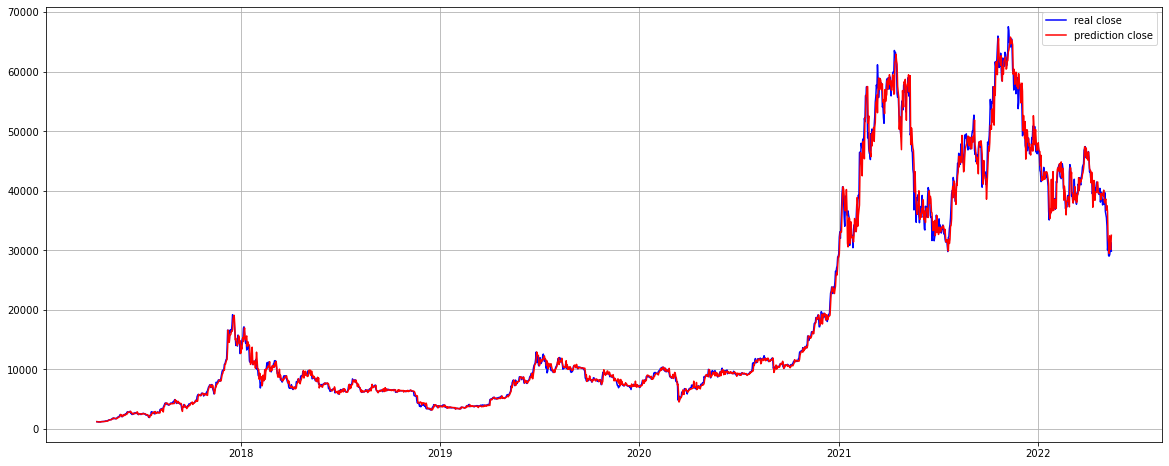

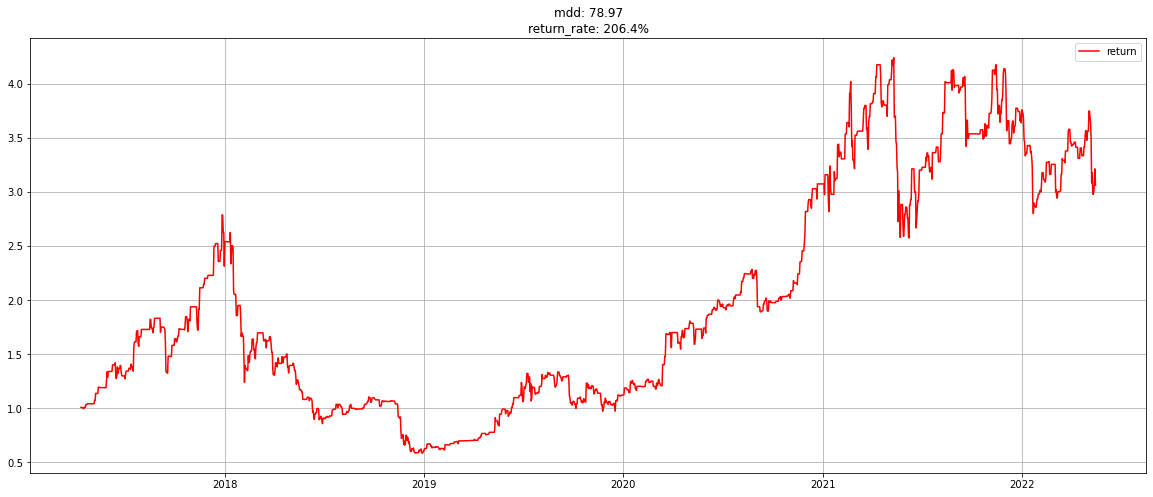

In [7]:
result_df = backtest_XGB_1d(final_price_df,100, 1)

In [8]:
analysis_return(result_df)

{'trade_rate': ' 46.51%',
 'success_rate': ' 53.58%',
 'pnl_rate': ' 1.16',
 'mdd': ' 78.97%',
 'cr': ' 206.40%'}

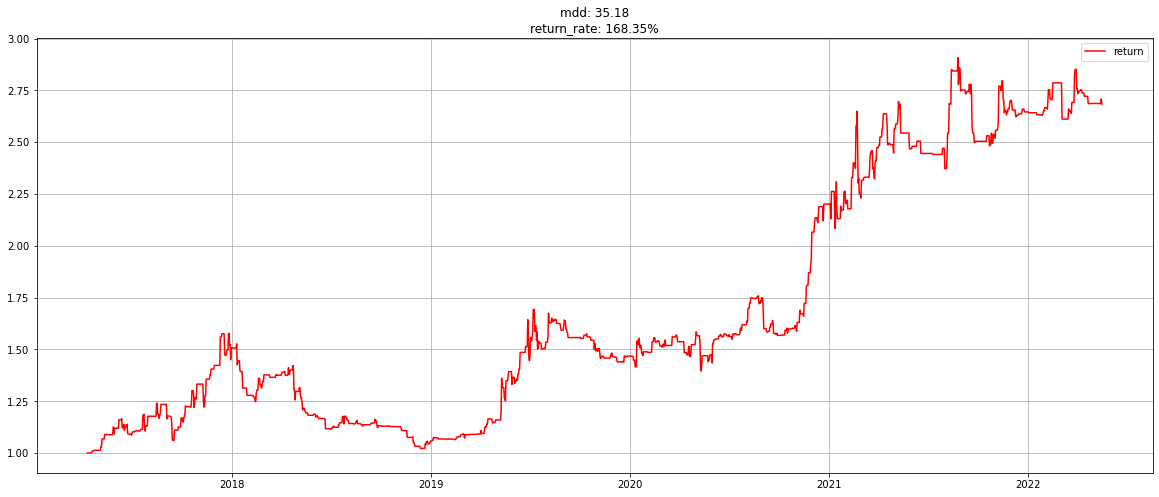

In [9]:
result_df = backtest_ma(result_df)
plot_return(result_df)

In [10]:
analysis_return(result_df)

{'trade_rate': ' 33.08%',
 'success_rate': ' 53.25%',
 'pnl_rate': ' 1.26',
 'mdd': ' 35.18%',
 'cr': ' 168.35%'}

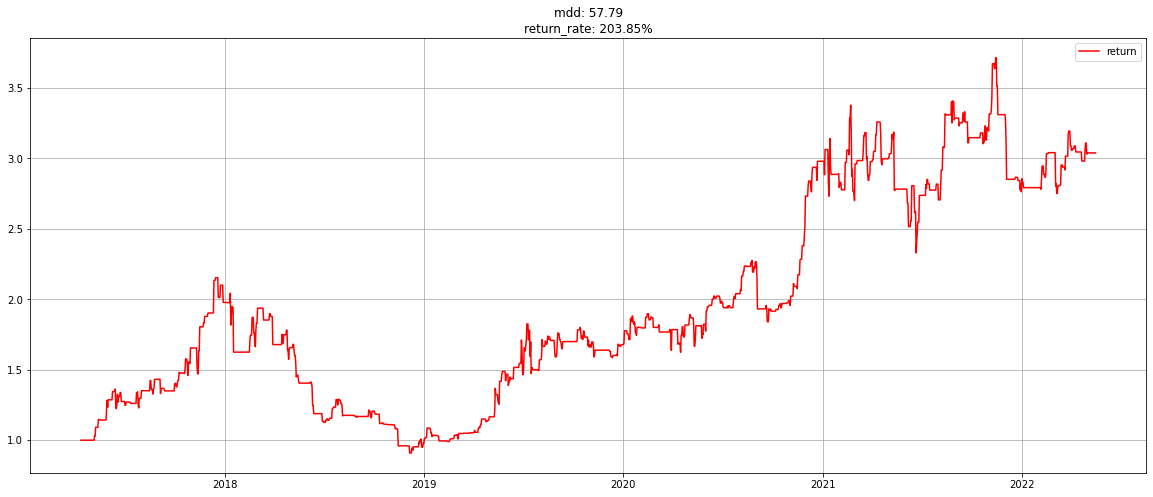

In [11]:
result_df = backtest_rsi(result_df)
plot_return(result_df)

In [12]:
analysis_return(result_df)

{'trade_rate': ' 30.34%',
 'success_rate': ' 53.45%',
 'pnl_rate': ' 1.22',
 'mdd': ' 57.79%',
 'cr': ' 203.85%'}

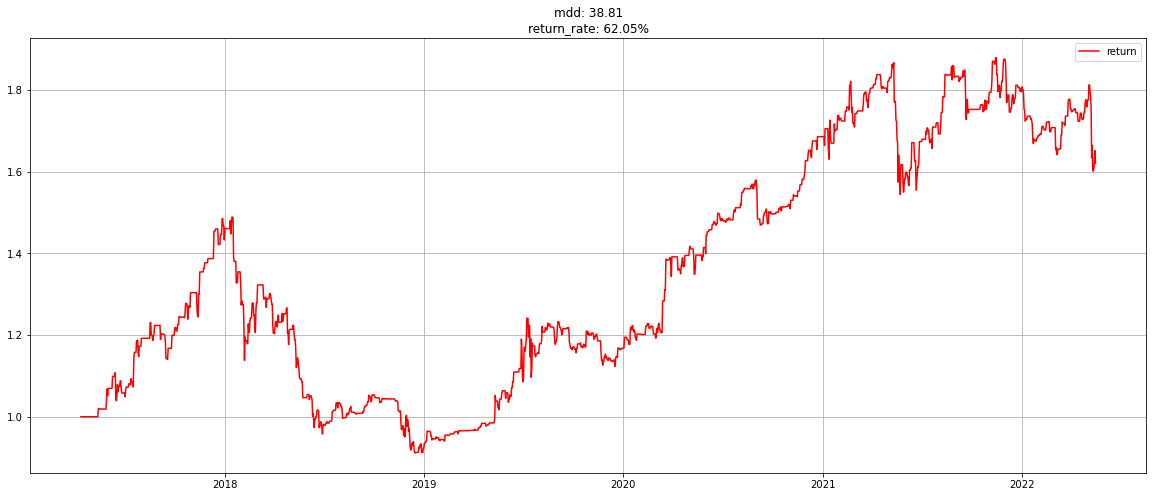

In [13]:
result_df = backtest_noise(result_df,df)
plot_return(result_df)

In [14]:
analysis_return(result_df)

{'trade_rate': ' 45.86%',
 'success_rate': ' 53.28%',
 'pnl_rate': ' 1.14',
 'mdd': ' 38.81%',
 'cr': ' 62.05%'}

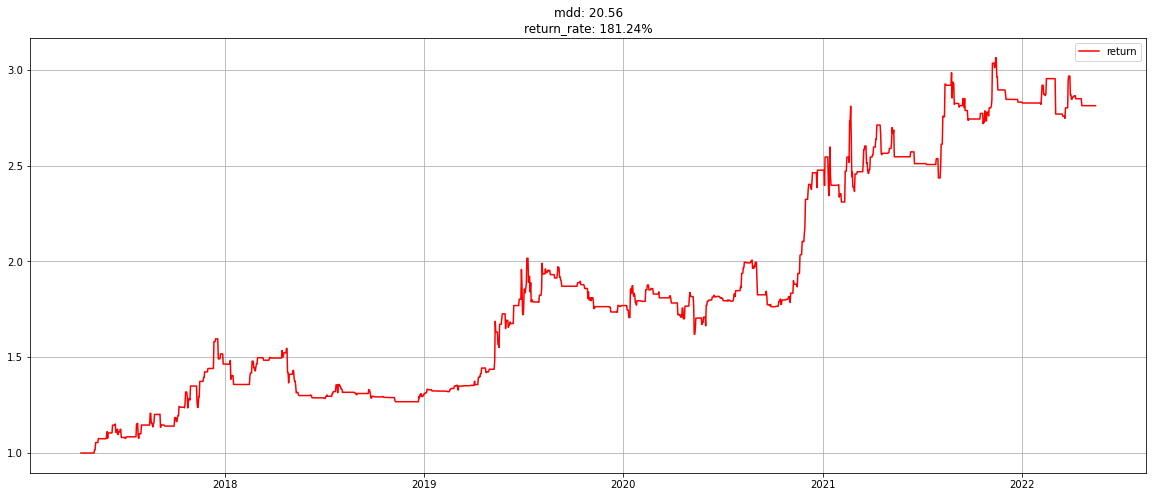

In [15]:
result_df = backtest_ma_and_rsi(result_df)
plot_return(result_df)

In [16]:
analysis_return(result_df)

{'trade_rate': ' 26.53%',
 'success_rate': ' 53.24%',
 'pnl_rate': ' 1.32',
 'mdd': ' 20.56%',
 'cr': ' 181.24%'}

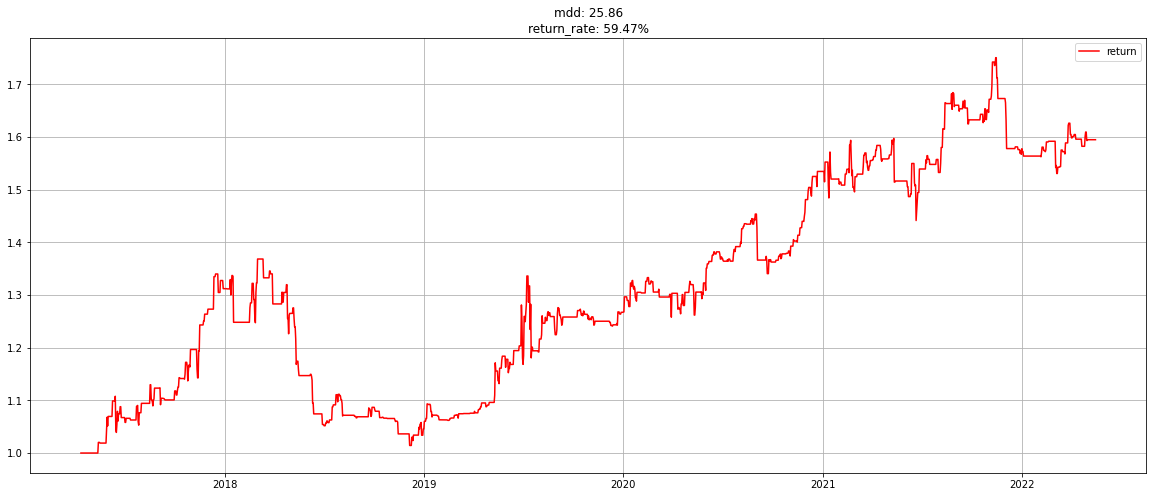

In [17]:
result_df = backtest_noise_and_rsi(result_df)
plot_return(result_df)

In [18]:
analysis_return(result_df)

{'trade_rate': ' 30.13%',
 'success_rate': ' 53.30%',
 'pnl_rate': ' 1.20',
 'mdd': ' 25.86%',
 'cr': ' 59.47%'}

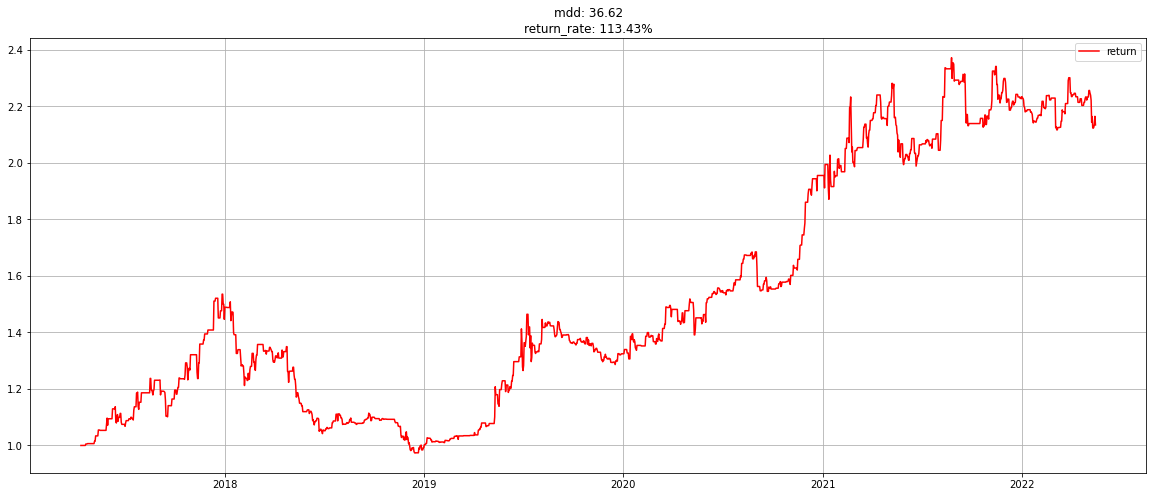

In [19]:
result_df = backtest_ma_and_noise(result_df)
plot_return(result_df)

In [20]:
analysis_return(result_df)

{'trade_rate': ' 46.24%',
 'success_rate': ' 53.54%',
 'pnl_rate': ' 1.20',
 'mdd': ' 36.62%',
 'cr': ' 113.43%'}

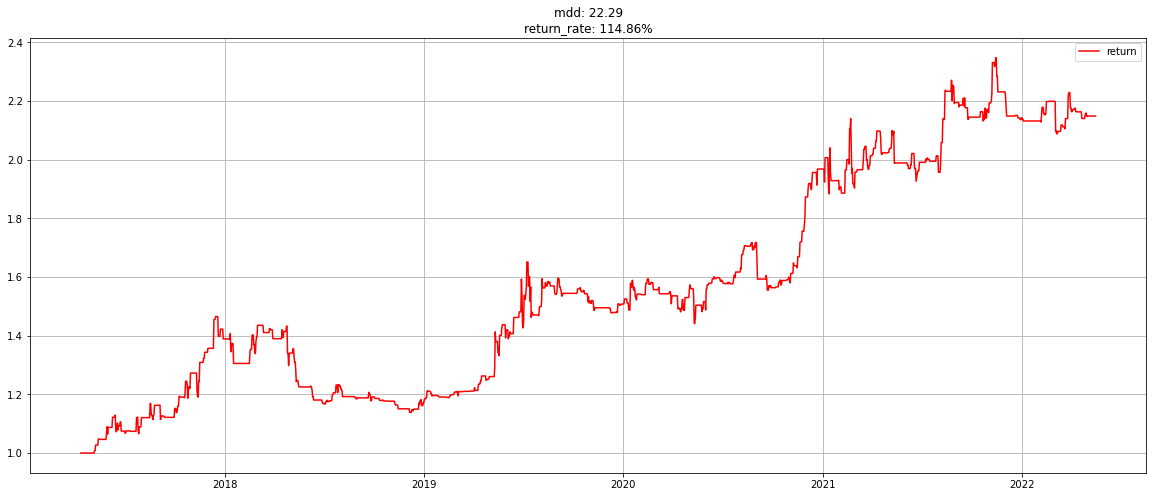

In [21]:
result_df = backtest_ma_and_rsi_and_noise(result_df)
plot_return(result_df)

In [22]:
analysis_return(result_df)

{'trade_rate': ' 30.34%',
 'success_rate': ' 53.45%',
 'pnl_rate': ' 1.27',
 'mdd': ' 22.29%',
 'cr': ' 114.86%'}

1662it [08:28,  3.27it/s]


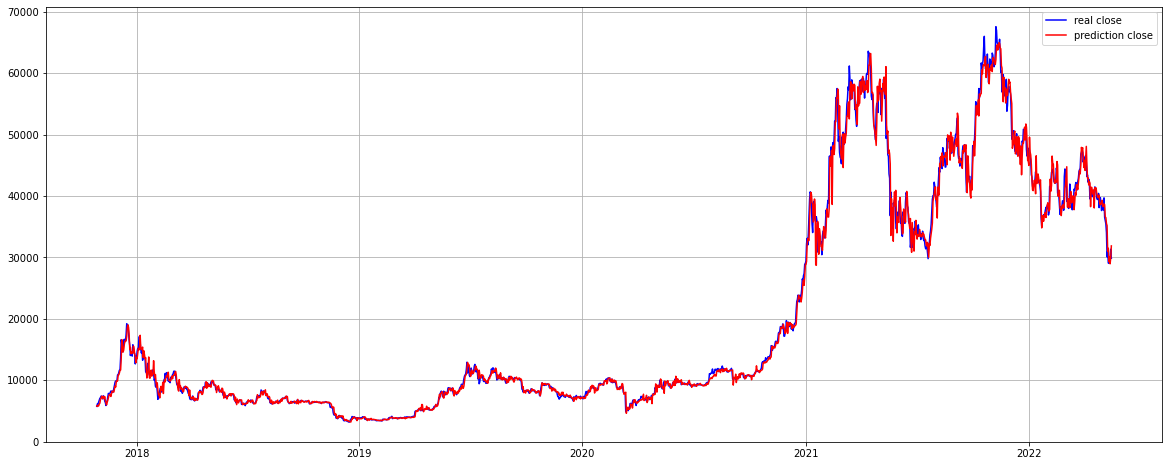

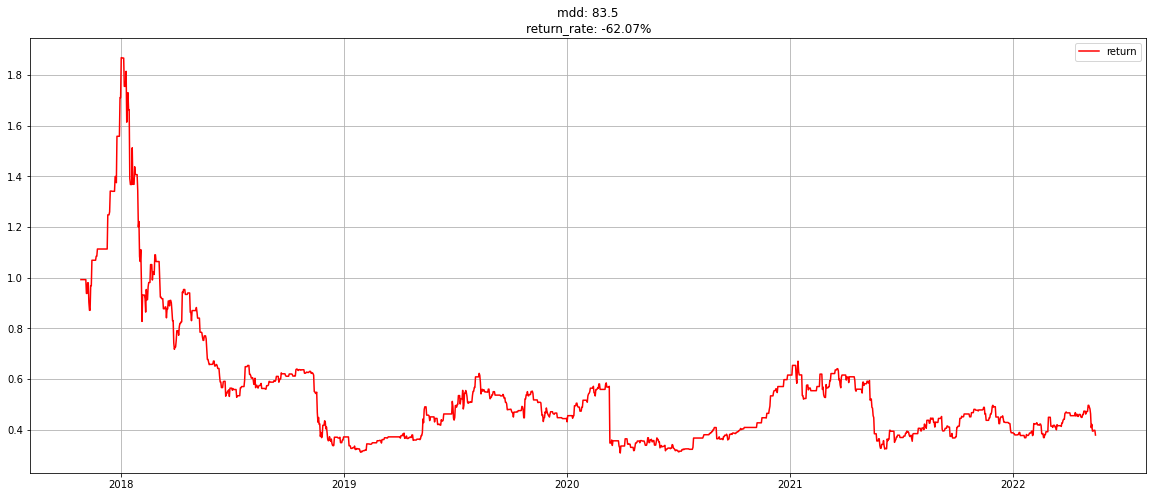

In [23]:
result_df = backtest_XGB_1d(final_price_df,300, 1)

In [24]:
analysis_return(result_df)

{'trade_rate': ' 47.41%',
 'success_rate': ' 51.90%',
 'pnl_rate': ' 0.99',
 'mdd': ' 83.50%',
 'cr': '-62.07%'}

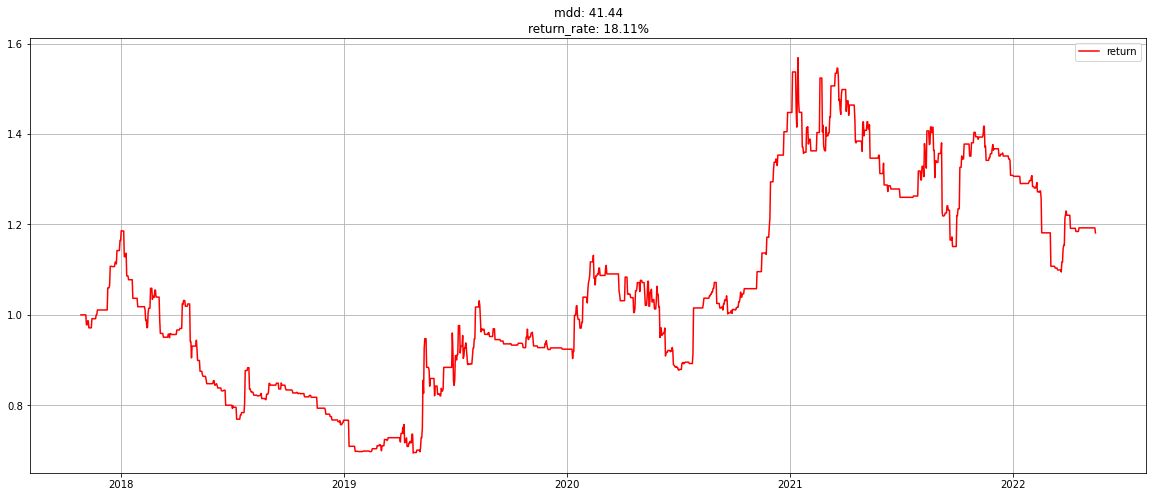

In [25]:
result_df = backtest_ma(result_df)
plot_return(result_df)

In [26]:
analysis_return(result_df)

{'trade_rate': ' 33.33%',
 'success_rate': ' 51.44%',
 'pnl_rate': ' 1.08',
 'mdd': ' 41.44%',
 'cr': ' 18.11%'}

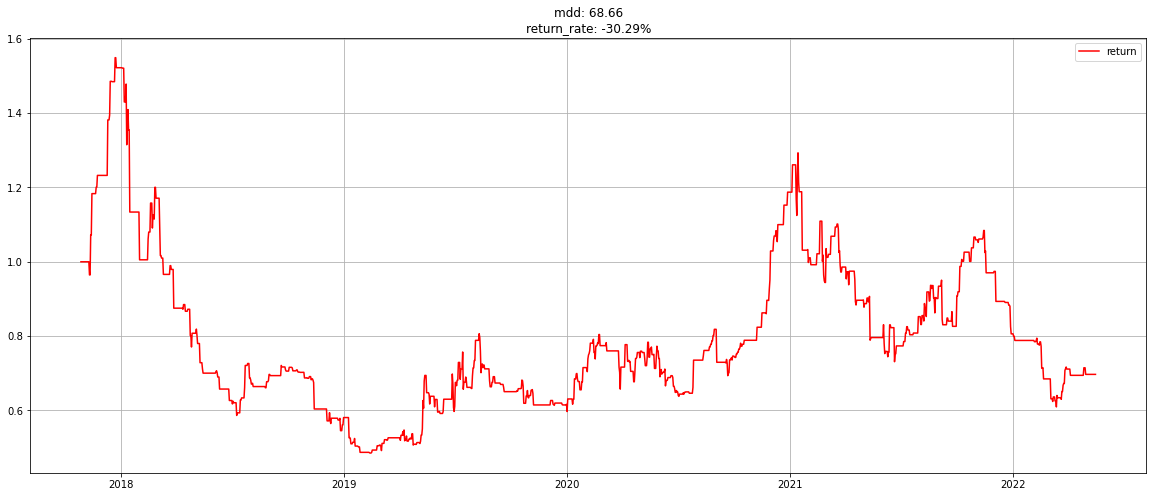

In [27]:
result_df = backtest_rsi(result_df)
plot_return(result_df)

In [28]:
analysis_return(result_df)

{'trade_rate': ' 30.99%',
 'success_rate': ' 51.46%',
 'pnl_rate': ' 1.01',
 'mdd': ' 68.66%',
 'cr': '-30.29%'}

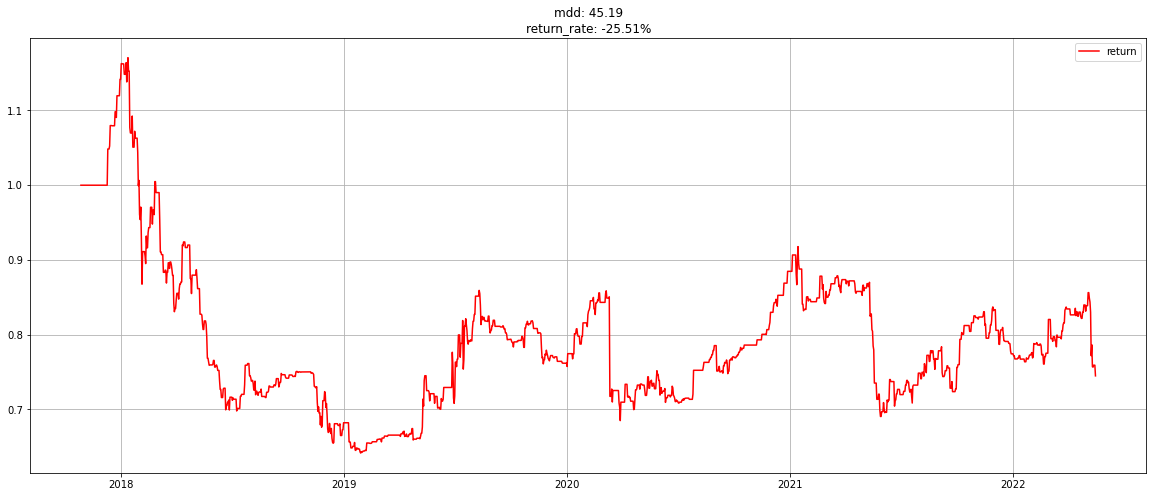

In [29]:
result_df = backtest_noise(result_df,df)
plot_return(result_df)

In [30]:
analysis_return(result_df)

{'trade_rate': ' 46.57%',
 'success_rate': ' 51.81%',
 'pnl_rate': ' 0.96',
 'mdd': ' 45.19%',
 'cr': '-25.51%'}

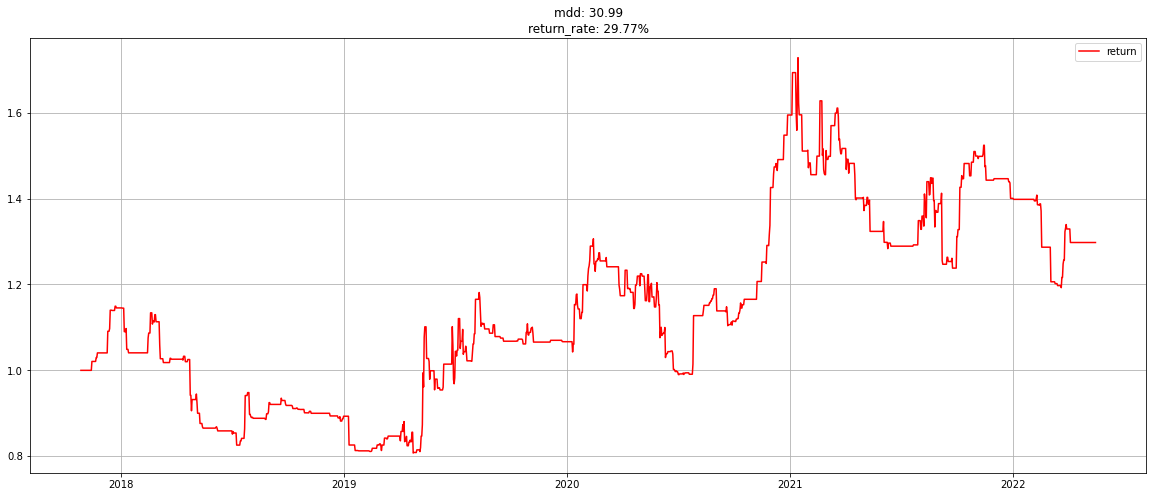

In [31]:
result_df = backtest_ma_and_rsi(result_df)
plot_return(result_df)

In [32]:
analysis_return(result_df)

{'trade_rate': ' 26.96%',
 'success_rate': ' 51.79%',
 'pnl_rate': ' 1.11',
 'mdd': ' 30.99%',
 'cr': ' 29.77%'}

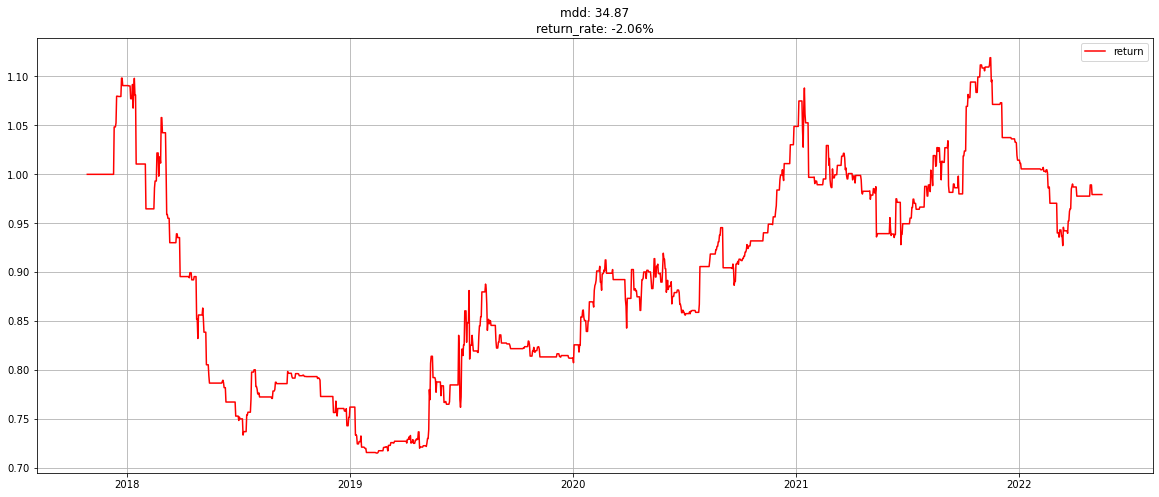

In [33]:
result_df = backtest_noise_and_rsi(result_df)
plot_return(result_df)

In [34]:
analysis_return(result_df)

{'trade_rate': ' 30.45%',
 'success_rate': ' 51.19%',
 'pnl_rate': ' 1.02',
 'mdd': ' 34.87%',
 'cr': '-2.06%'}

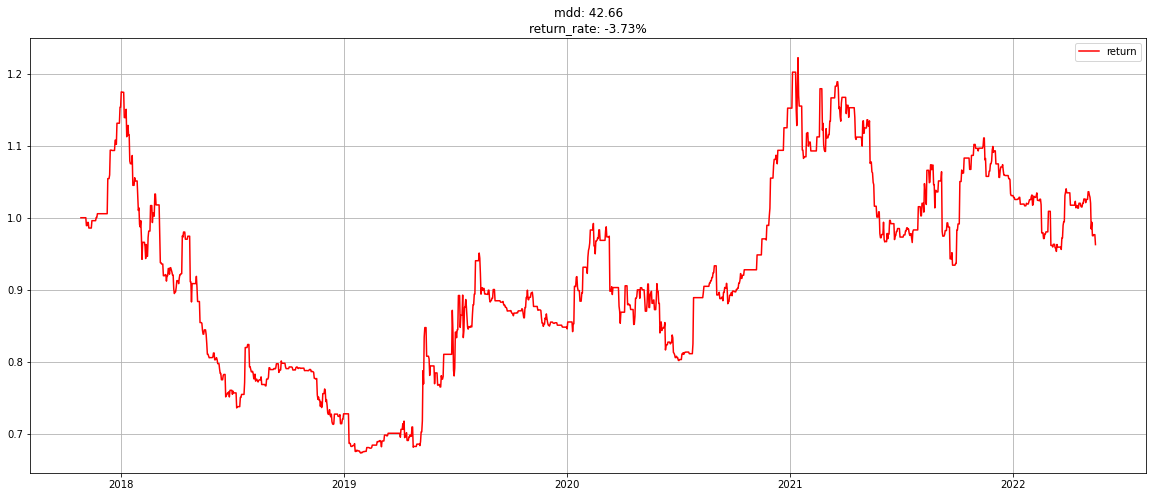

In [35]:
result_df = backtest_ma_and_noise(result_df)
plot_return(result_df)

In [36]:
analysis_return(result_df)

{'trade_rate': ' 47.17%',
 'success_rate': ' 51.91%',
 'pnl_rate': ' 1.02',
 'mdd': ' 42.66%',
 'cr': '-3.73%'}

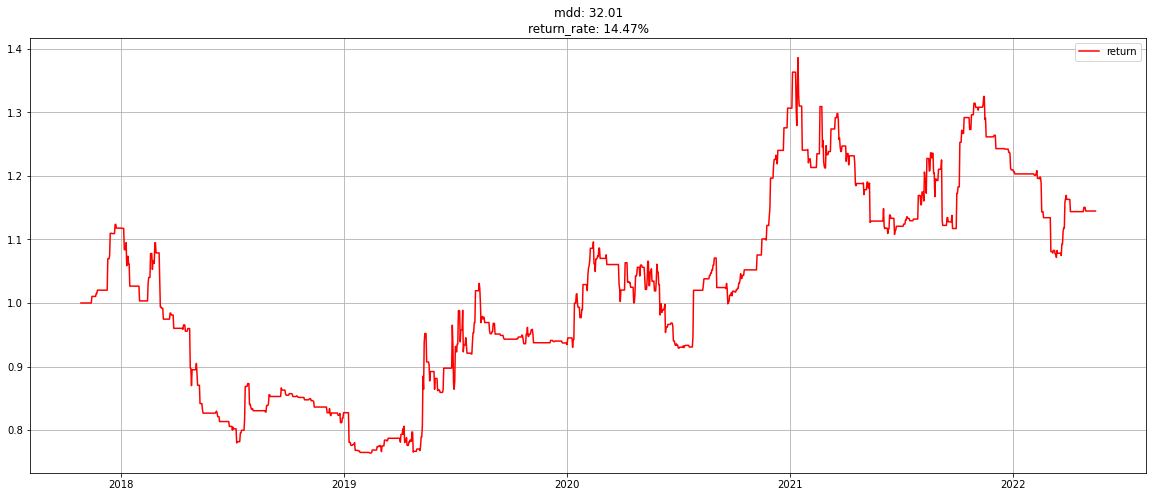

In [37]:
result_df = backtest_ma_and_rsi_and_noise(result_df)
plot_return(result_df)

In [38]:
analysis_return(result_df)

{'trade_rate': ' 30.87%',
 'success_rate': ' 51.46%',
 'pnl_rate': ' 1.07',
 'mdd': ' 32.01%',
 'cr': ' 14.47%'}

1912it [05:10,  6.17it/s]


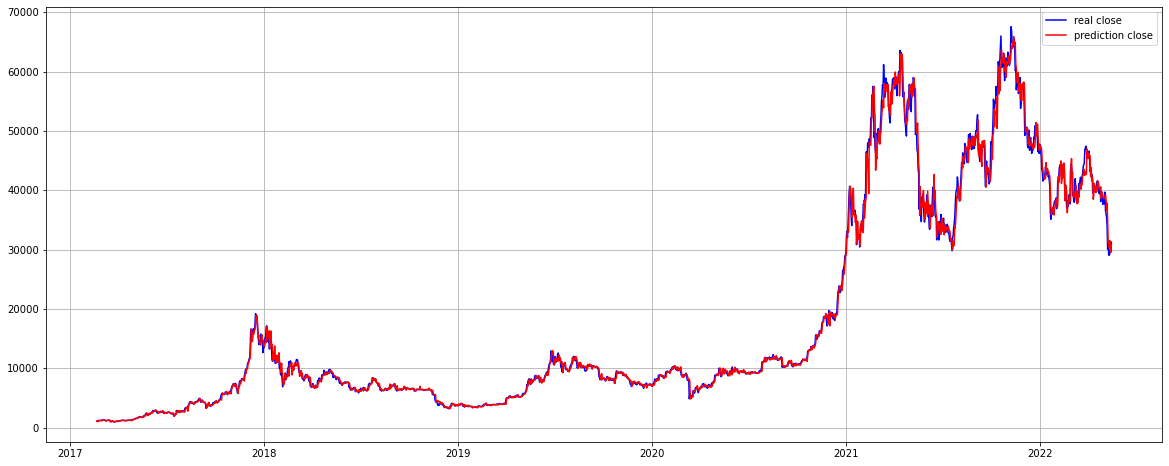

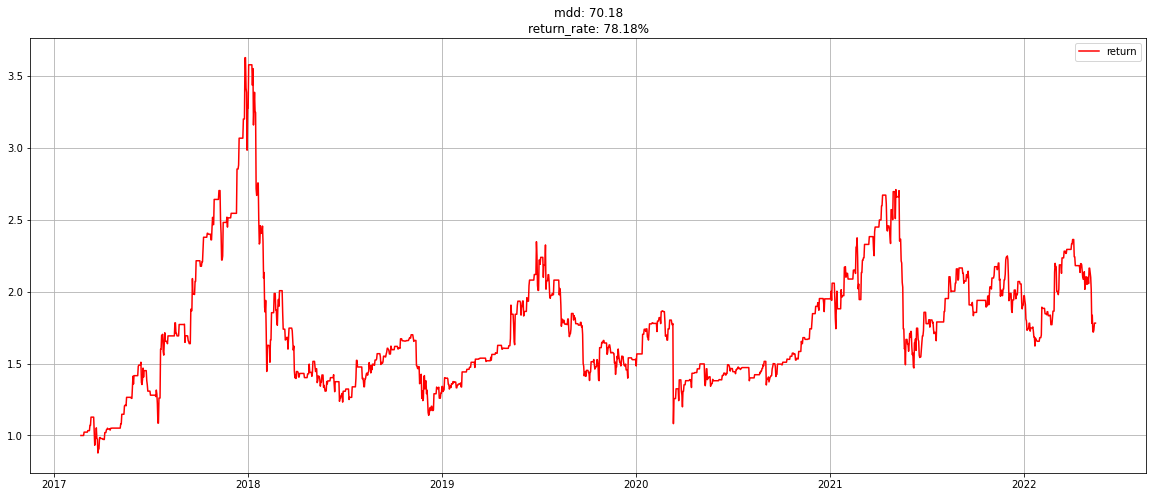

In [39]:
result_df = backtest_XGB_1d(final_price_df,50, 1)

## 네이버 트랜드 지수만 추가 

In [99]:
test_df=df[:]
test_df=Merge_NT(test_df,0,20)
test_df=Merge_DJI(test_df)
test_df=Merge_ECR(test_df)
test_df=Merge_HR(test_df)
price_df=test_df[:]
OBV_preprocessing(price_df)
preprocessing(price_df,10)
gen_train_test2(price_df)
price_df=price_df.reset_index(drop=True)
final_price_df=price_df
final_price_df.set_index('Date',inplace=True,drop=True)
final_price_df=price_df.drop(['High','Low'],axis=1)

In [100]:
final_price_df

,Open,Close,Volume,trend_index,trend_index_20mean,dji_c,dji_v,exc_c,hash-rate,obv,...,p_lag_8,q_lag_8,pq_lag_8,p_lag_9,q_lag_9,pq_lag_9,p_lag_10,q_lag_10,pq_lag_10,target
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,966.34,998.80,6.579904e+06,0.09546,0.419328,19881.76,339180000.0,1203.93,2.589950e+06,0.000000e+00,...,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,1014.10
2017-01-02,997.75,1014.10,8.190255e+06,0.19901,0.419328,19881.76,339180000.0,1203.93,2.589950e+06,8.190255e+06,...,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,1036.99
2017-01-03,1011.44,1036.99,8.955193e+06,0.31354,0.419328,19881.76,339180000.0,1206.82,2.589950e+06,1.714545e+07,...,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,1122.56
2017-01-04,1035.51,1122.56,2.325716e+07,0.29935,0.419328,19942.16,280010000.0,1196.15,2.589950e+06,4.040261e+07,...,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,994.02
2017-01-05,1114.38,994.02,3.503690e+07,2.39445,0.419328,19899.29,269920000.0,1182.19,2.589950e+06,5.365705e+06,...,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,-1.0,-1.000,-1.000000e+00,891.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12,29077.90,29020.70,9.644756e+05,10.04609,2.560432,31730.04,525900000.0,1290.72,2.097226e+08,-6.743164e+08,...,39684.0,424498.818,1.684581e+10,37712.9,248986.222,9.389992e+09,38525.6,336845.365,1.297717e+10,29274.30
2022-05-13,29020.80,29274.30,5.076201e+05,6.25849,2.814953,32195.94,374100000.0,1278.45,2.361321e+08,-6.738088e+08,...,36534.7,547209.000,1.999212e+10,39684.0,424498.818,1.684581e+10,37712.9,248986.222,9.389992e+09,30079.80
2022-05-14,29274.20,30079.80,3.157569e+05,3.45666,2.931416,32195.94,374100000.0,1278.45,2.190436e+08,-6.734930e+08,...,35995.3,431979.240,1.554922e+10,36534.7,547209.000,1.999212e+10,39684.0,424498.818,1.684581e+10,31324.40


1862it [06:14,  4.97it/s]


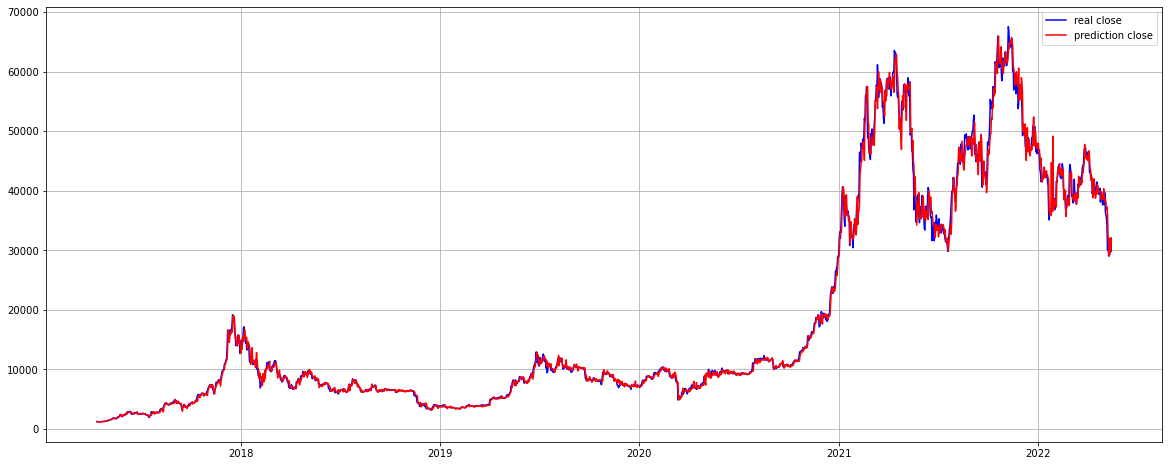

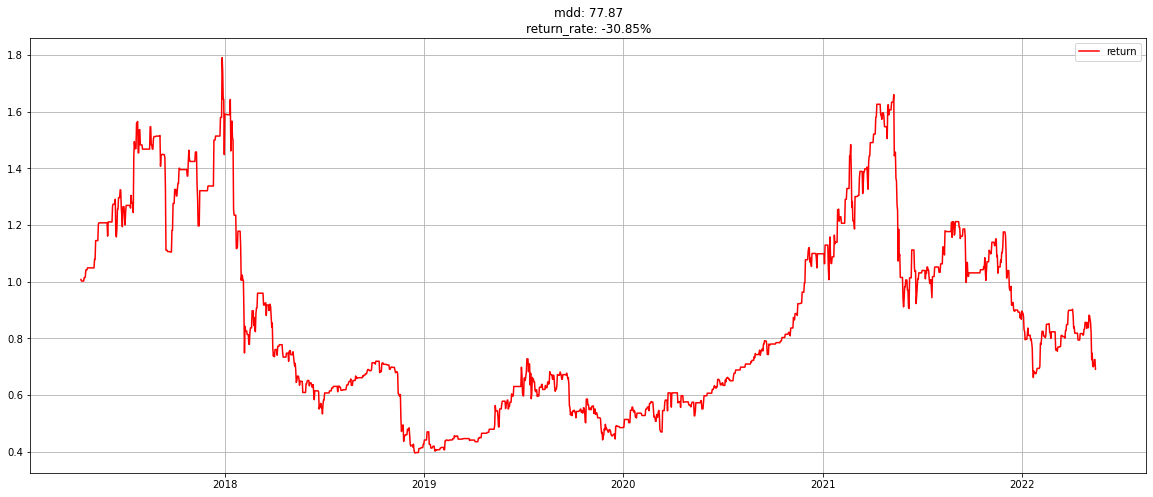

In [101]:
result_df = backtest_XGB_1d(final_price_df,100, 1)

In [102]:
analysis_return(result_df)

{'trade_rate': ' 44.90%',
 'success_rate': ' 52.63%',
 'pnl_rate': ' 1.03',
 'mdd': ' 77.87%',
 'cr': '-30.85%'}

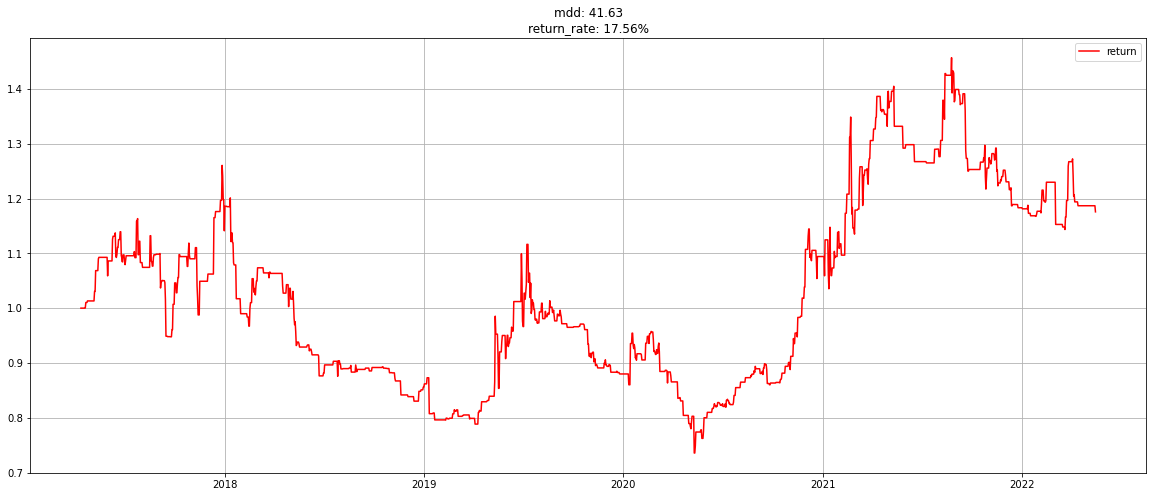

In [45]:
result_df = backtest_ma(result_df)
plot_return(result_df)

In [46]:
analysis_return(result_df)

{'trade_rate': ' 31.04%',
 'success_rate': ' 52.25%',
 'pnl_rate': ' 1.07',
 'mdd': ' 41.63%',
 'cr': ' 17.56%'}

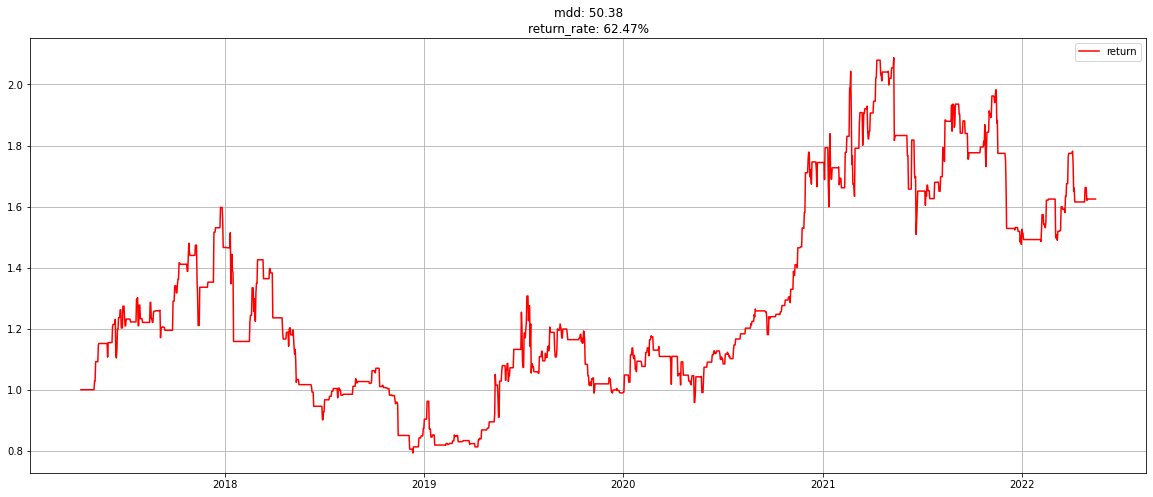

In [47]:
result_df = backtest_rsi(result_df)
plot_return(result_df)

In [48]:
analysis_return(result_df)

{'trade_rate': ' 28.46%',
 'success_rate': ' 53.58%',
 'pnl_rate': ' 1.13',
 'mdd': ' 50.38%',
 'cr': ' 62.47%'}

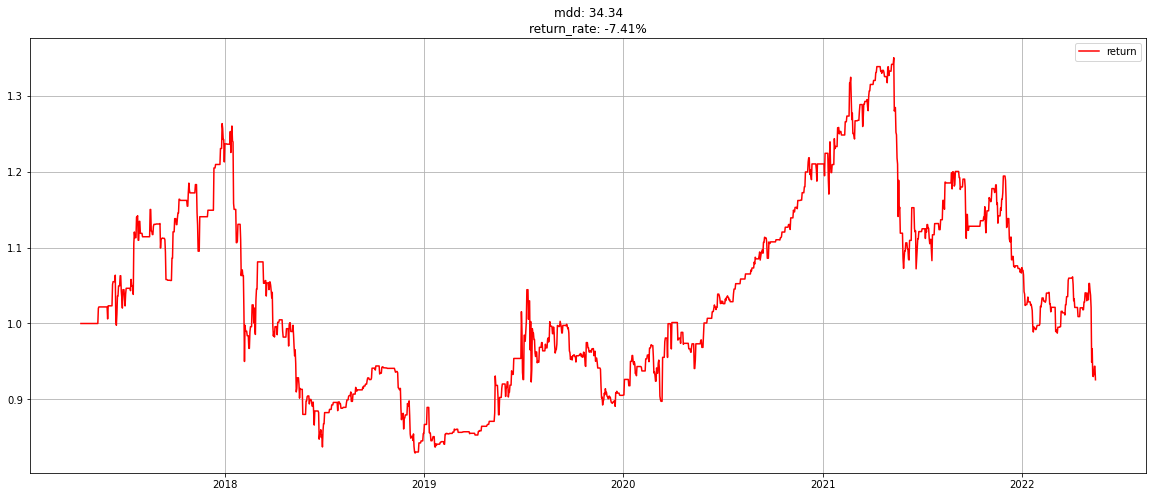

In [49]:
result_df = backtest_noise(result_df,df)
plot_return(result_df)

In [50]:
analysis_return(result_df)

{'trade_rate': ' 44.20%',
 'success_rate': ' 52.25%',
 'pnl_rate': ' 1.01',
 'mdd': ' 34.34%',
 'cr': '-7.41%'}

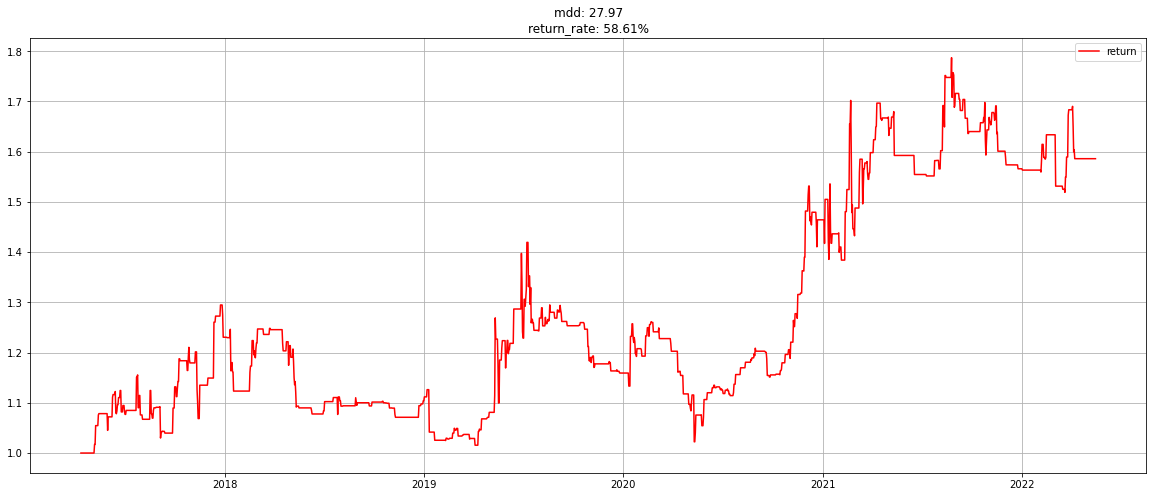

In [51]:
result_df = backtest_ma_and_rsi(result_df)
plot_return(result_df)

In [52]:
analysis_return(result_df)

{'trade_rate': ' 24.49%',
 'success_rate': ' 53.51%',
 'pnl_rate': ' 1.17',
 'mdd': ' 27.97%',
 'cr': ' 58.61%'}

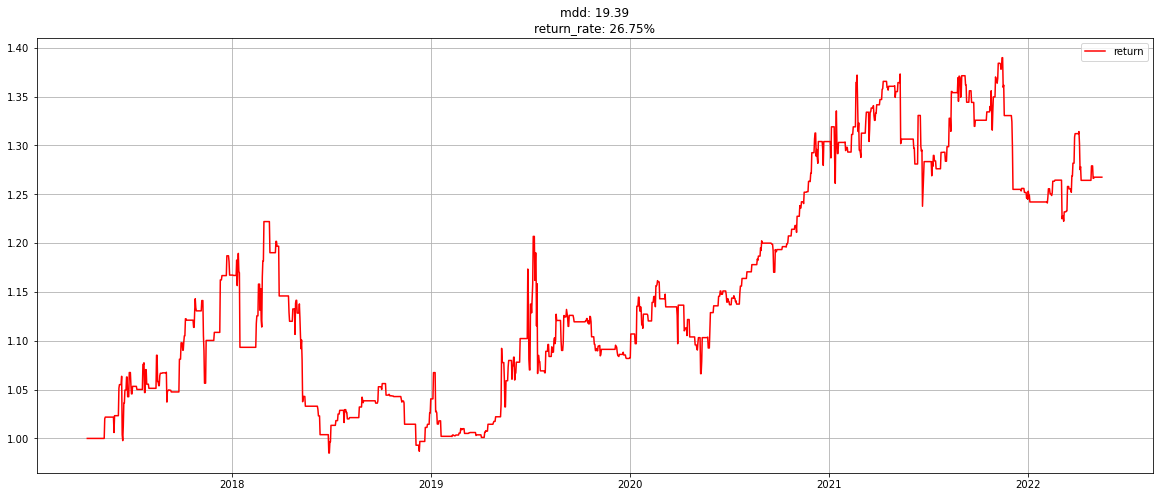

In [53]:
result_df = backtest_noise_and_rsi(result_df)
plot_return(result_df)

In [54]:
analysis_return(result_df)

{'trade_rate': ' 28.20%',
 'success_rate': ' 53.52%',
 'pnl_rate': ' 1.12',
 'mdd': ' 19.39%',
 'cr': ' 26.75%'}

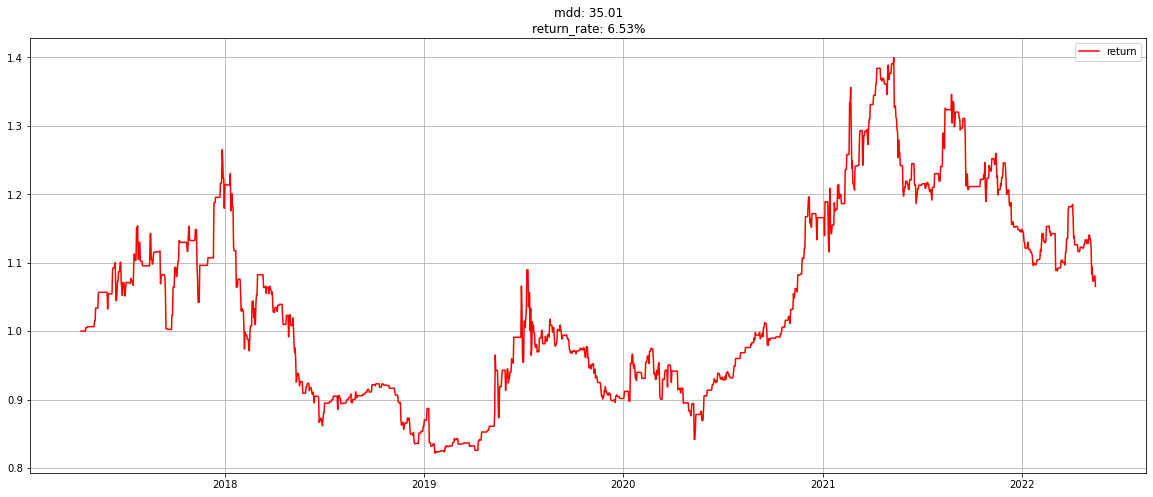

In [55]:
result_df = backtest_ma_and_noise(result_df)
plot_return(result_df)

In [56]:
analysis_return(result_df)

{'trade_rate': ' 44.63%',
 'success_rate': ' 52.47%',
 'pnl_rate': ' 1.04',
 'mdd': ' 35.01%',
 'cr': ' 6.53%'}

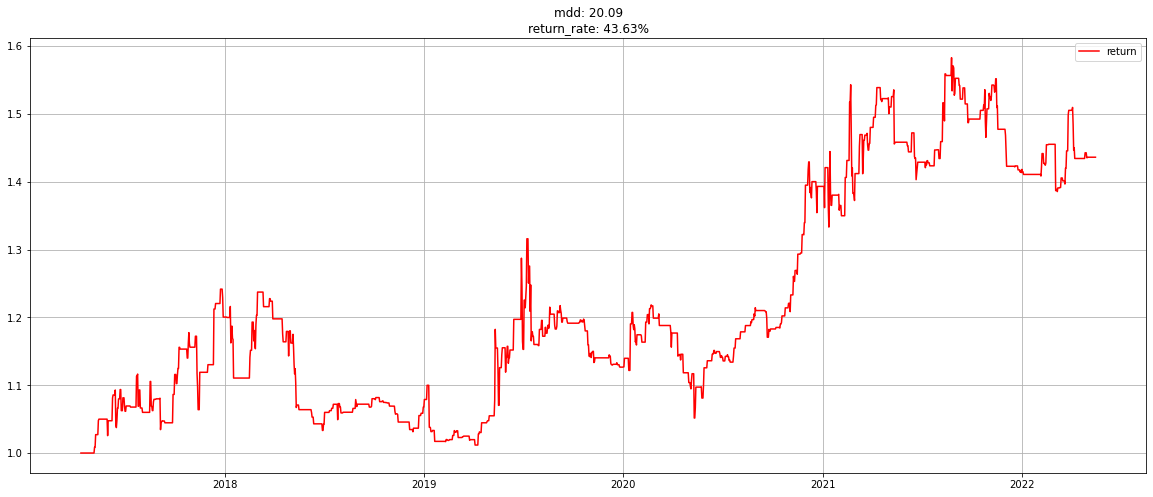

In [57]:
result_df = backtest_ma_and_rsi_and_noise(result_df)
plot_return(result_df)

In [58]:
analysis_return(result_df)

{'trade_rate': ' 28.46%',
 'success_rate': ' 53.58%',
 'pnl_rate': ' 1.15',
 'mdd': ' 20.09%',
 'cr': ' 43.63%'}

1662it [07:45,  3.57it/s]


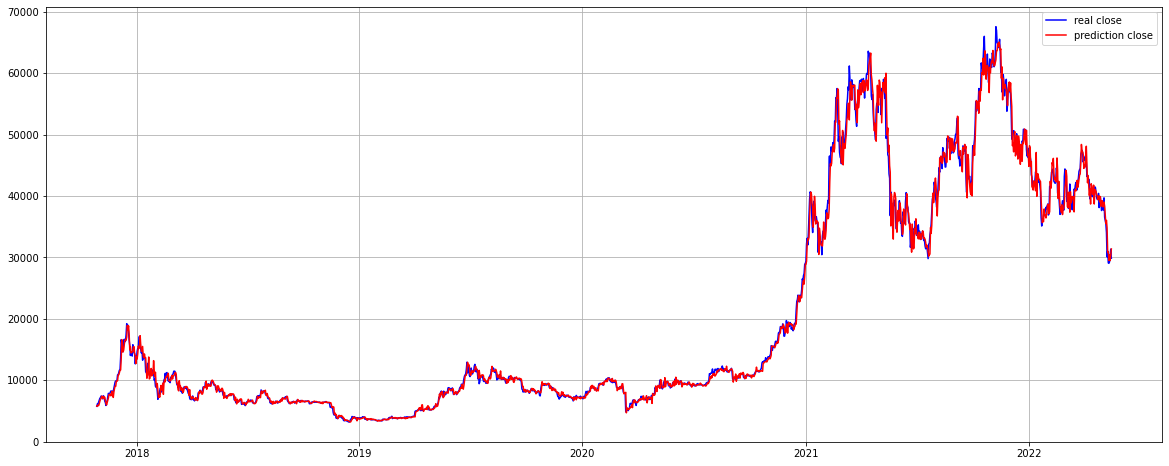

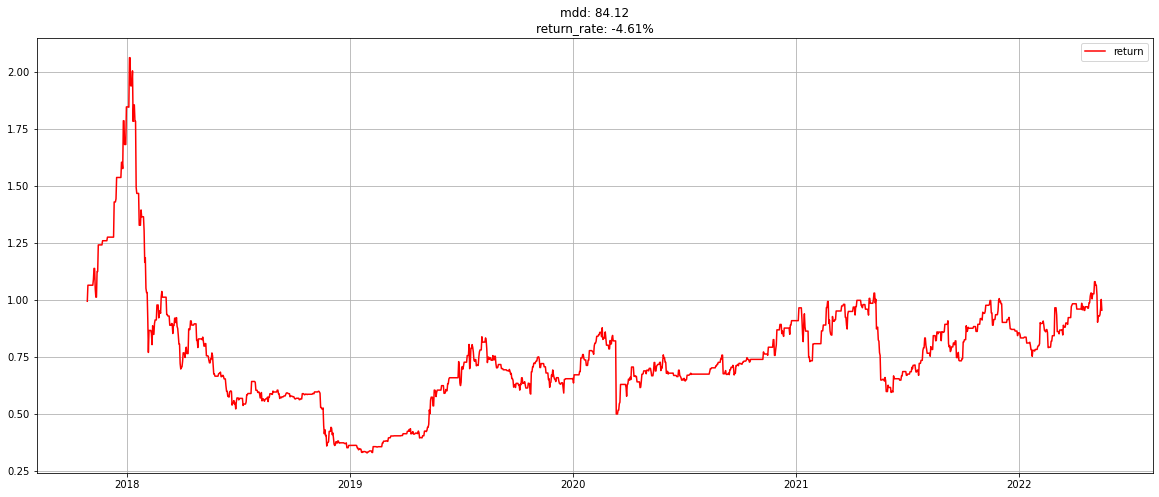

In [59]:
result_df = backtest_XGB_1d(final_price_df,300, 1)

### 두지수 모두 전처리 후 넣어서 결과 비교 

In [82]:
test_df=df[:]
test_df=Merge_FnG(test_df,30,30)
test_df=Merge_NT(test_df,0,20)
test_df=Merge_DJI(test_df)
test_df=Merge_ECR(test_df)
test_df=Merge_HR(test_df)
price_df=test_df[:]
OBV_preprocessing(price_df)
preprocessing(price_df,10)
gen_train_test2(price_df)
price_df=price_df.reset_index(drop=True)
final_price_df=price_df
final_price_df.set_index('Date',inplace=True,drop=True)
final_price_df=price_df.drop(['High','Low','trend_index'],axis=1)

1862it [06:26,  4.82it/s]


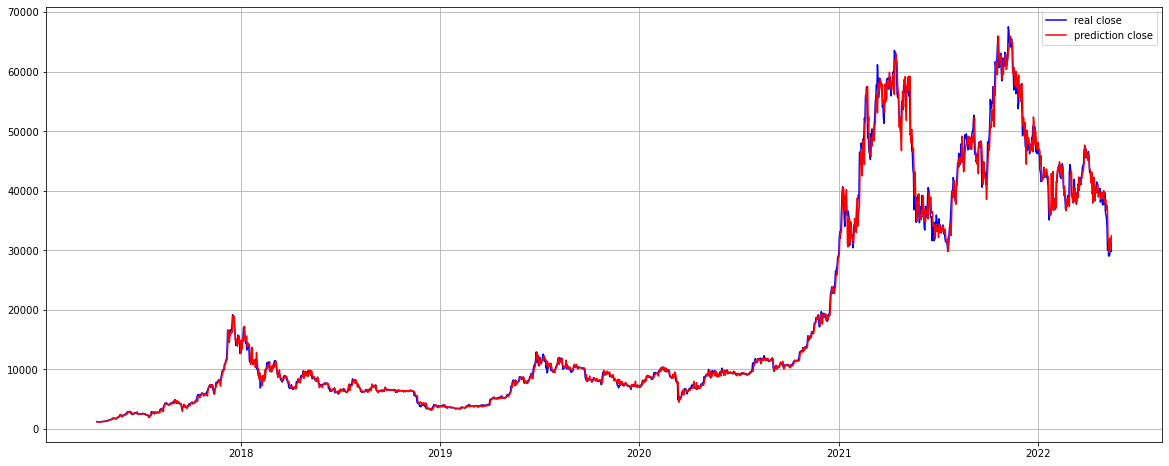

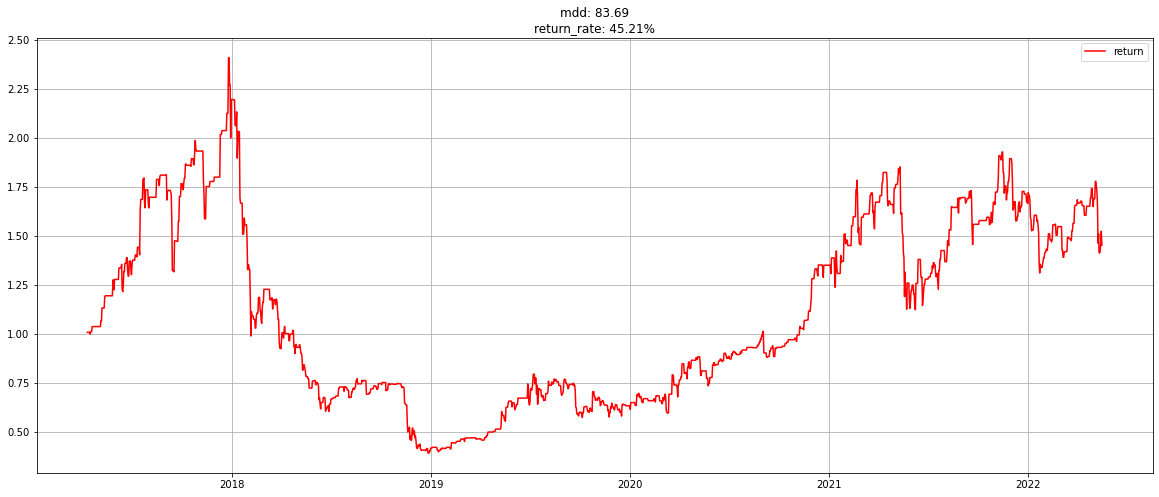

In [83]:
result_df = backtest_XGB_1d(final_price_df,100, 1)

In [84]:
analysis_return(result_df)

{'trade_rate': ' 44.84%',
 'success_rate': ' 53.29%',
 'pnl_rate': ' 1.10',
 'mdd': ' 83.69%',
 'cr': ' 45.21%'}

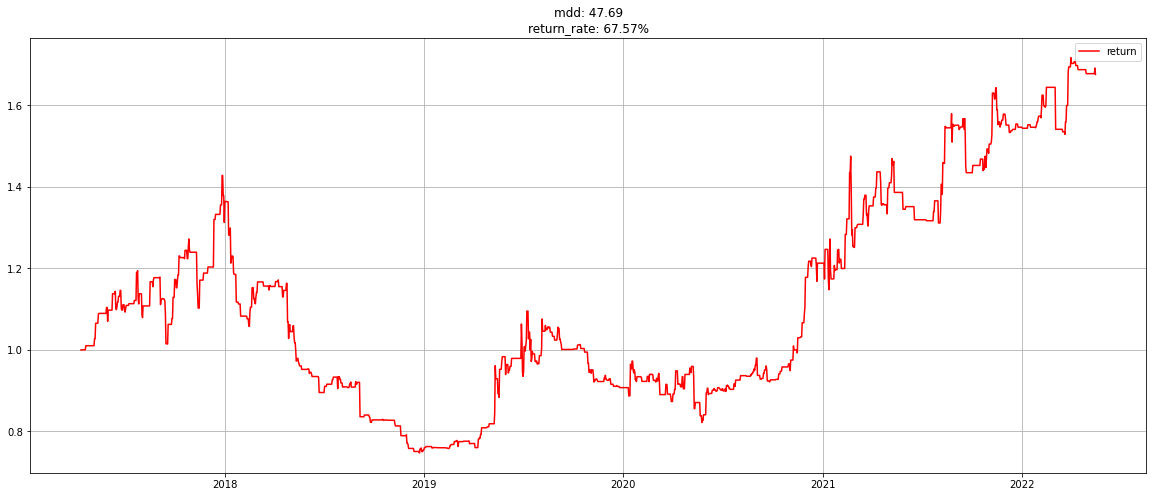

In [85]:
result_df = backtest_ma(result_df)
plot_return(result_df)

In [86]:
analysis_return(result_df)

{'trade_rate': ' 31.58%',
 'success_rate': ' 52.72%',
 'pnl_rate': ' 1.16',
 'mdd': ' 47.69%',
 'cr': ' 67.57%'}

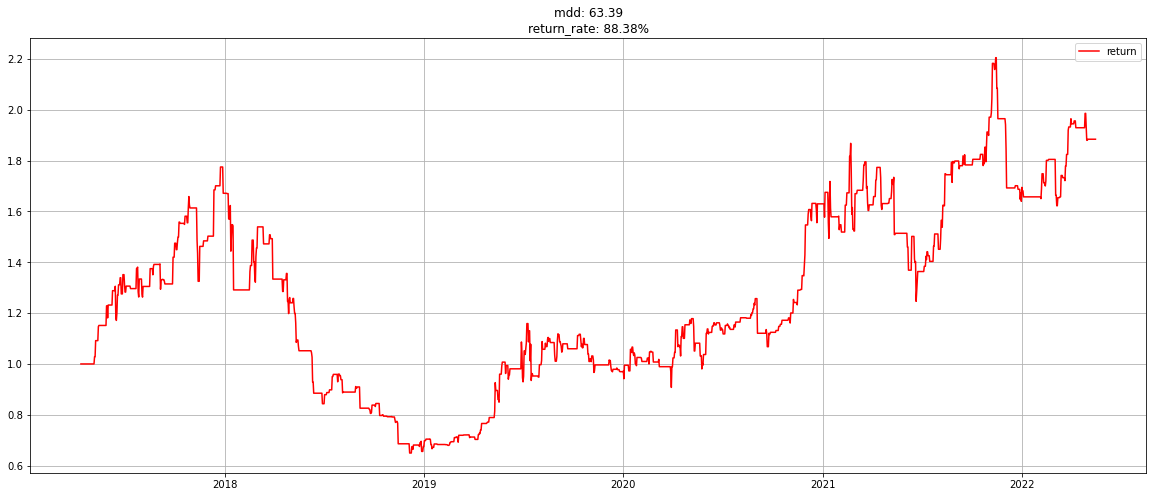

In [87]:
result_df = backtest_rsi(result_df)
plot_return(result_df)

In [88]:
analysis_return(result_df)

{'trade_rate': ' 28.95%',
 'success_rate': ' 53.43%',
 'pnl_rate': ' 1.15',
 'mdd': ' 63.39%',
 'cr': ' 88.38%'}

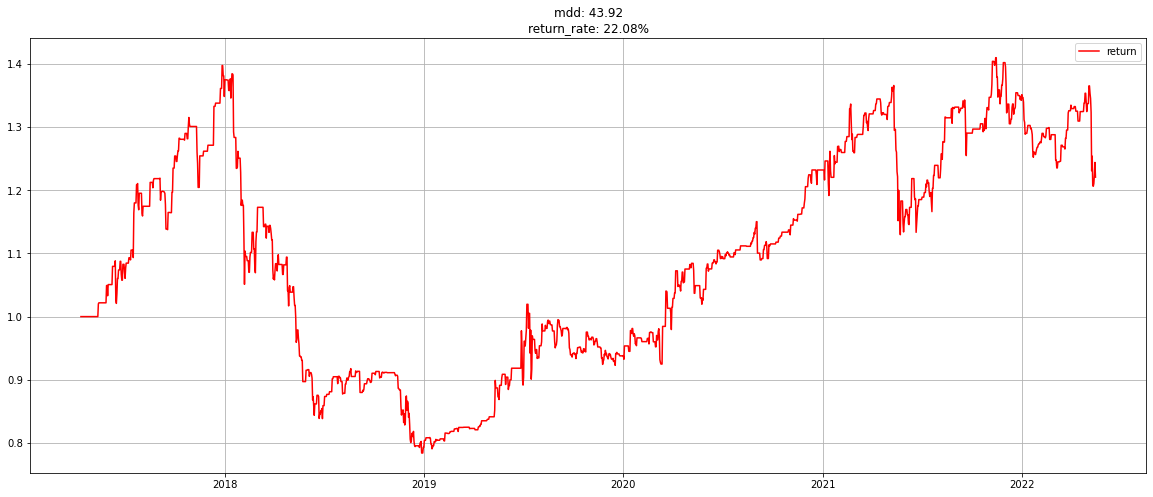

In [89]:
result_df = backtest_noise(result_df,df)
plot_return(result_df)

In [90]:
analysis_return(result_df)

{'trade_rate': ' 44.31%',
 'success_rate': ' 52.97%',
 'pnl_rate': ' 1.07',
 'mdd': ' 43.92%',
 'cr': ' 22.08%'}

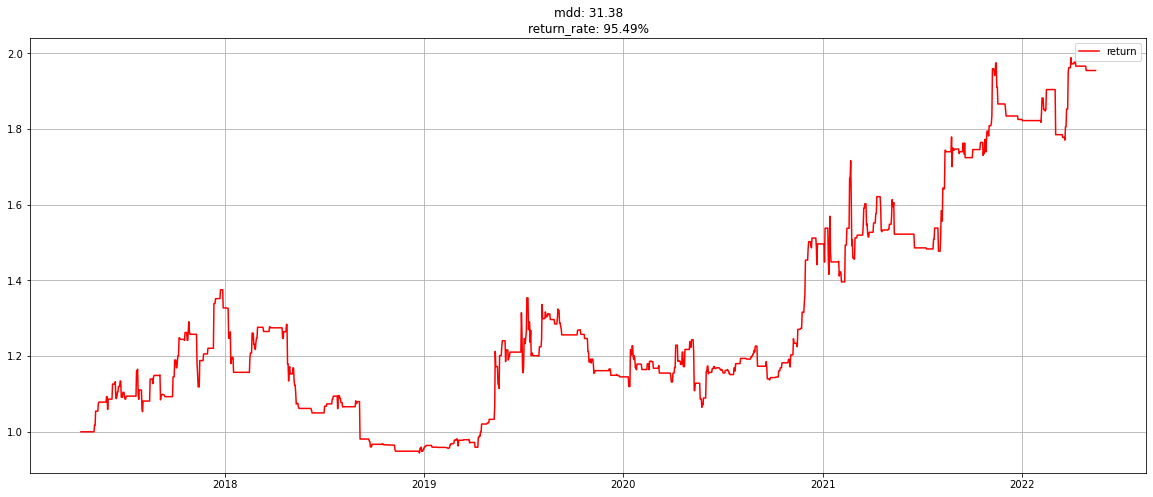

In [91]:
result_df = backtest_ma_and_rsi(result_df)
plot_return(result_df)

In [92]:
analysis_return(result_df)

{'trade_rate': ' 25.03%',
 'success_rate': ' 53.22%',
 'pnl_rate': ' 1.23',
 'mdd': ' 31.38%',
 'cr': ' 95.49%'}

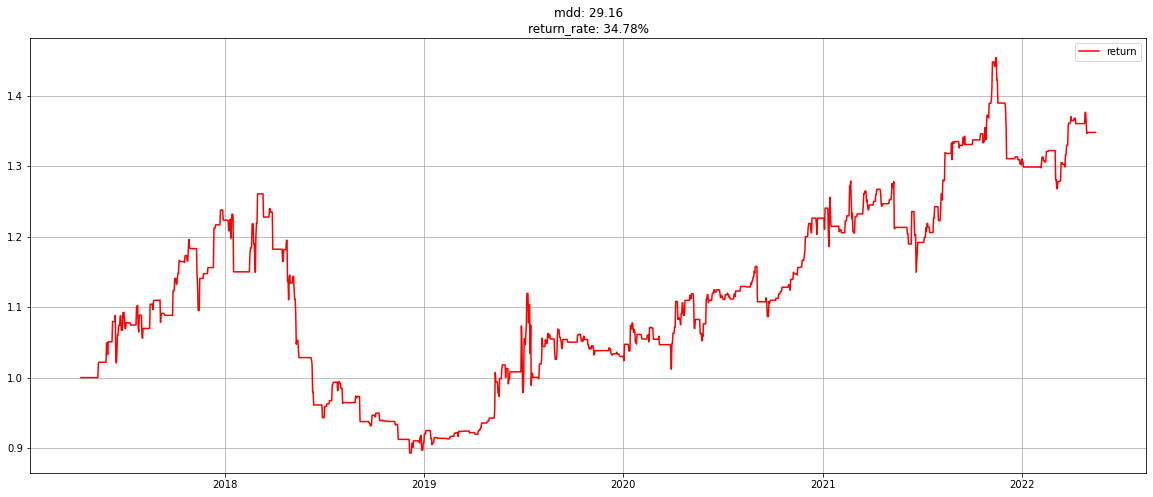

In [93]:
result_df = backtest_noise_and_rsi(result_df)
plot_return(result_df)

In [94]:
analysis_return(result_df)

{'trade_rate': ' 28.73%',
 'success_rate': ' 53.27%',
 'pnl_rate': ' 1.14',
 'mdd': ' 29.16%',
 'cr': ' 34.78%'}

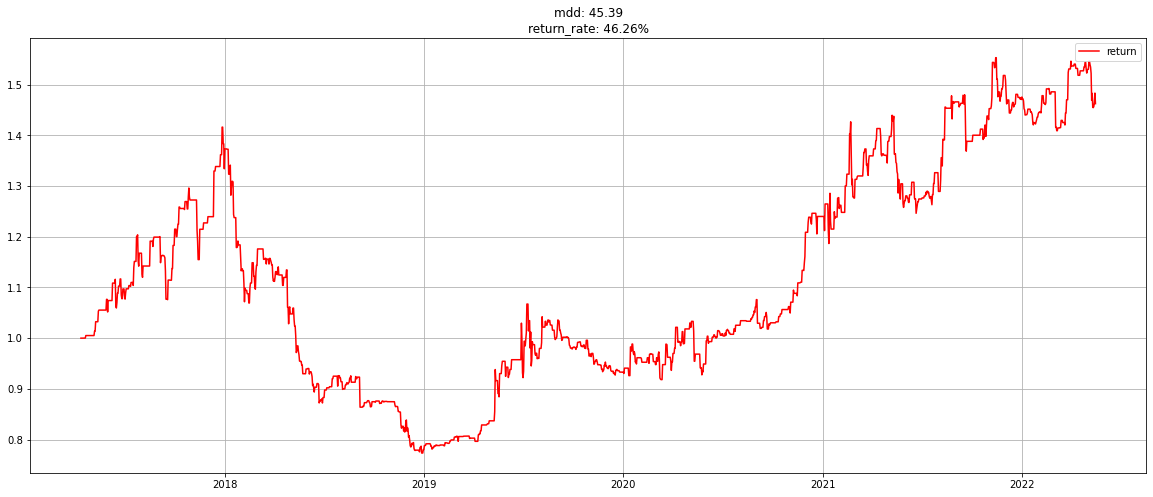

In [95]:
result_df = backtest_ma_and_noise(result_df)
plot_return(result_df)

In [96]:
analysis_return(result_df)

{'trade_rate': ' 44.63%',
 'success_rate': ' 53.19%',
 'pnl_rate': ' 1.11',
 'mdd': ' 45.39%',
 'cr': ' 46.26%'}

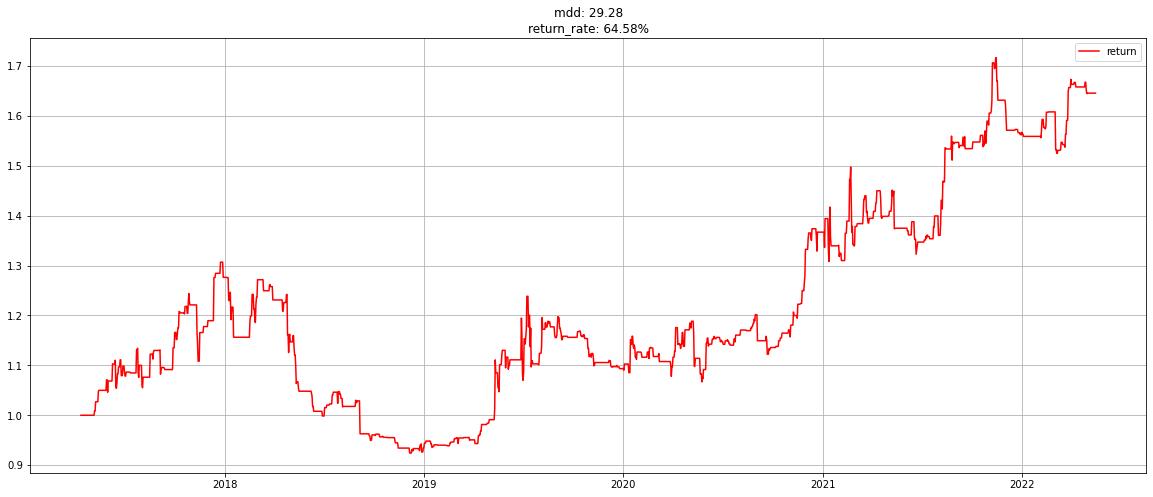

In [97]:
result_df = backtest_ma_and_rsi_and_noise(result_df)
plot_return(result_df)

In [98]:
analysis_return(result_df)

{'trade_rate': ' 28.95%',
 'success_rate': ' 53.43%',
 'pnl_rate': ' 1.19',
 'mdd': ' 29.28%',
 'cr': ' 64.58%'}